In [29]:
import pickle
import joblib

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB

pd.set_option('display.max_rows', None)

## 1. Data understanding

In [5]:
%%time
# pkl файл быстрее открывается , чем csv (%%time)
with open('ga_hits.pkl', 'rb') as f:
    df_hits = pickle.load(f)

Wall time: 1min 2s


In [87]:
%%time
with open('ga_sessions.pkl', 'rb') as f:
    df_sessions = pickle.load(f)

Wall time: 3.57 s


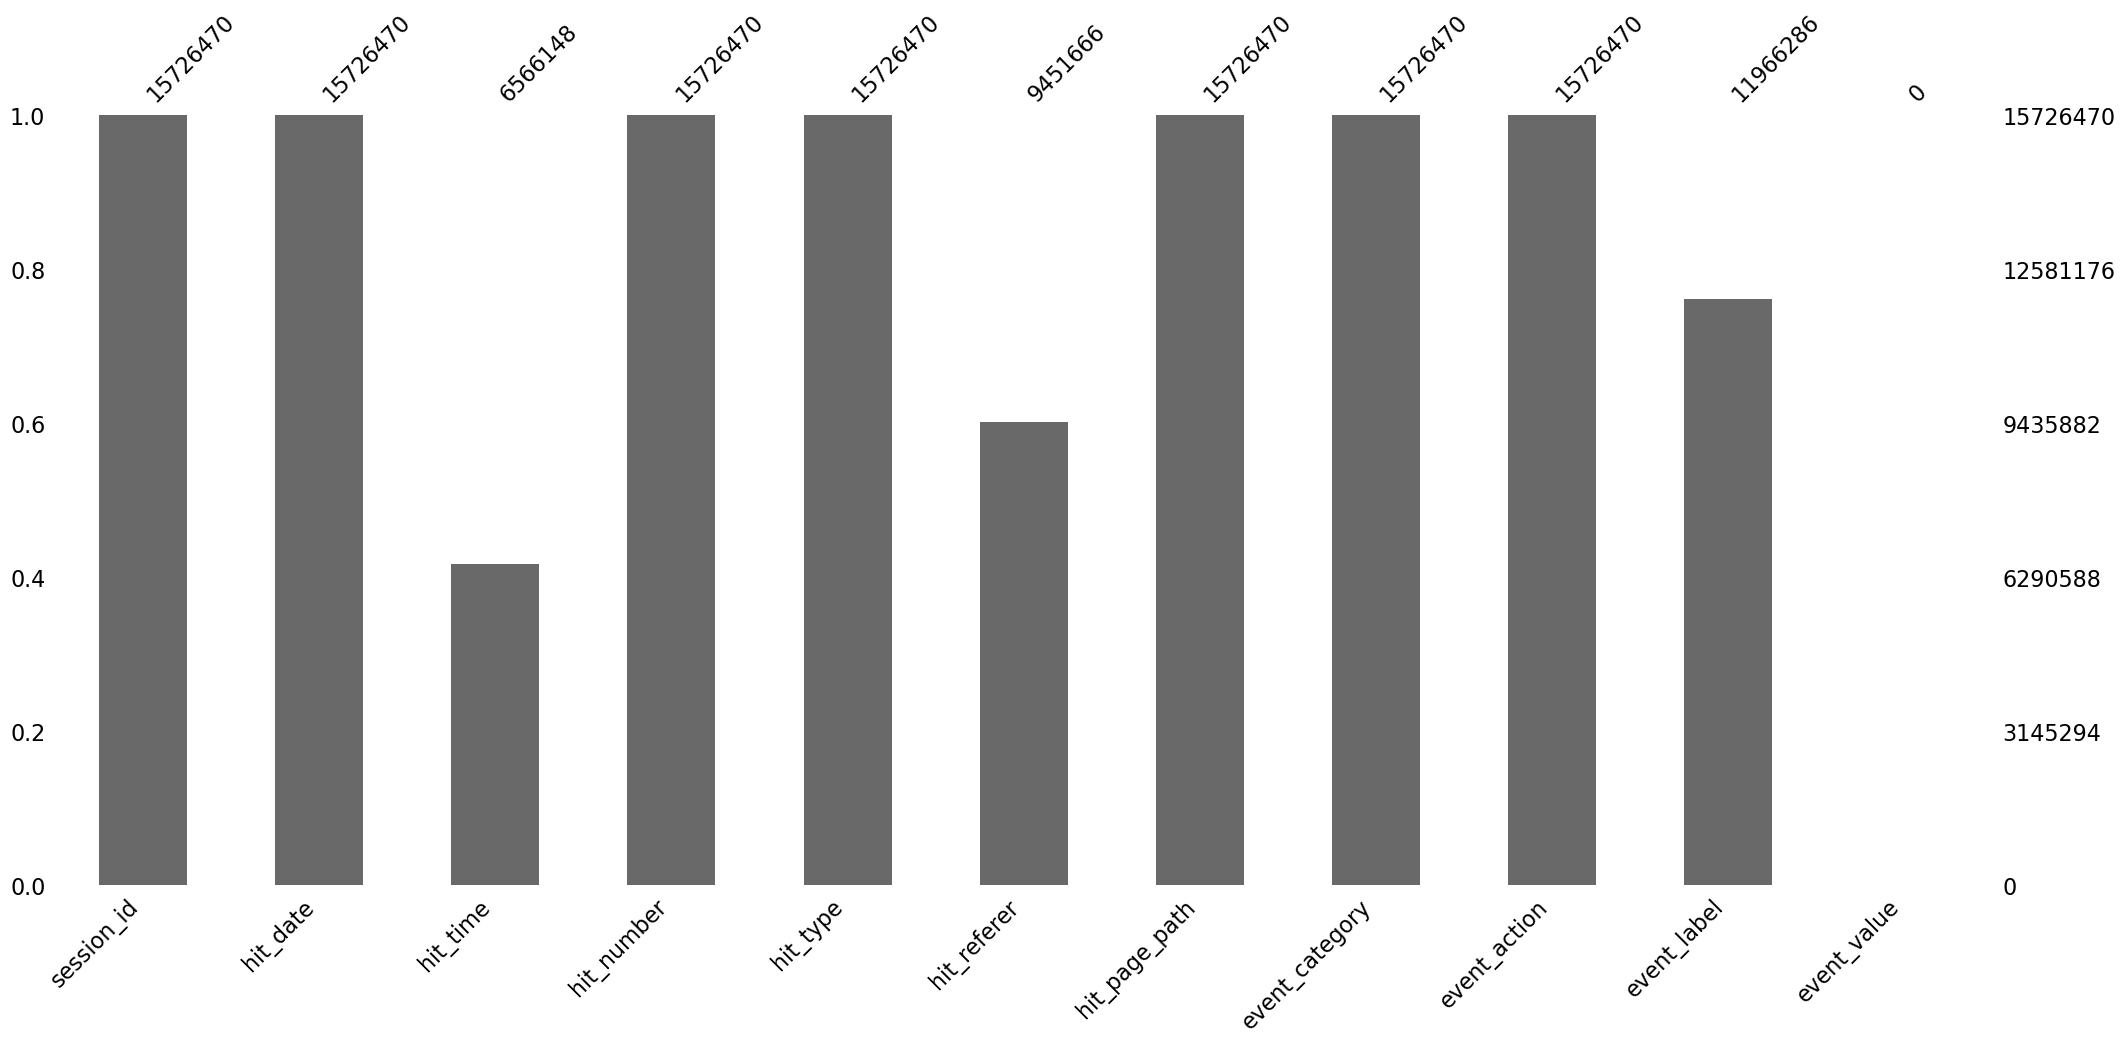

In [6]:
msno.bar(df_hits);

In [7]:
df_hits_cut = df_hits.drop(columns=['event_value', 'hit_page_path', 'hit_time', 'hit_referer'])
print(df_hits_cut.shape)
df_hits_cut.head(10)

(15726470, 7)


,session_id,hit_date,hit_number,hit_type,event_category,event_action,event_label
0,5639623078712724064.1640254056.1640254056,2021-12-23,30,event,quiz,quiz_show,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,41,event,quiz,quiz_show,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,49,event,quiz,quiz_show,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,46,event,quiz,quiz_show,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,79,event,quiz,quiz_show,NaN
5,6466333295973247896.1640246168.1640246168,2021-12-23,41,event,quiz,quiz_show,NaN
6,281215510786615563.1640245516.1640245516,2021-12-23,102,event,quiz,quiz_show,NaN
7,4024492994895054107.1640269084.1640269084,2021-12-23,85,event,quiz,quiz_show,NaN
8,555009234841130092.1640256620.1640256620,2021-12-23,101,event,quiz,quiz_show,NaN
9,2692901778487480807.1640206845.1640206845,2021-12-23,1,event,card_web,view_card,NaN


In [8]:
print(df_sessions.shape)
df_sessions.head(10)

(1860042, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
5,9055447192389856083.1622453074.1622453074,2108385598.1622453075,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
6,9055455318486370642.1640843788.1640843788,2108387490.1640843602,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg
8,9055462349345527315.1638536723.1638536723,2108389127.1638536723,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow
9,9055466554104774132.1624800757.1624800757,2108390106.1624800756,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Samsung,NaN,412x915,Chrome,Russia,Moscow


In [ ]:
# Сохраним обрезанный df_hits в файл
with open('df_hits_cut.pkl', 'wb') as file:
    pickle.dump(df_hits_cut, file)

In [5]:
%%time
# Откроем
with open('df_hits_cut.pkl', 'rb') as f:
    df_hits_cut = pickle.load(f)

Wall time: 14.5 s


In [ ]:
targets = [
    'sub_car_claim_click', 'sub_car_claim_submit_click',
    'sub_open_dialog_click', 'sub_custom_question_submit_click',
    'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
    'sub_car_request_submit_click'
]
df_hits_cut['target'] = df_hits_cut.apply(lambda x: 1 if x.event_action in targets else 0, axis=1)

In [17]:
df_hits_cut.target.value_counts(dropna=False)

0    15621562
1      104908
Name: target, dtype: int64

In [18]:
# Сохраним обрезанный df_hits в файл
with open('df_hits_cut.pkl', 'wb') as file:
    pickle.dump(df_hits_cut, file)

In [7]:
df_hits_cut.head(5)

,session_id,hit_date,hit_number,hit_type,event_category,event_action,event_label,target
0,5639623078712724064.1640254056.1640254056,2021-12-23,30,event,quiz,quiz_show,NaN,0
1,7750352294969115059.1640271109.1640271109,2021-12-23,41,event,quiz,quiz_show,NaN,0
2,885342191847998240.1640235807.1640235807,2021-12-23,49,event,quiz,quiz_show,NaN,0
3,142526202120934167.1640211014.1640211014,2021-12-23,46,event,quiz,quiz_show,NaN,0
4,3450086108837475701.1640265078.1640265078,2021-12-23,79,event,quiz,quiz_show,NaN,0


In [9]:
df_hits_group = df_hits_cut.groupby(['session_id'], as_index=False).agg({'target': 'max'})
print(df_hits_group.shape)

(1734610, 2)


In [11]:
df_hits_group.iloc[500:1000,:]

,session_id,target
500,1002339441732888125.1624909374.1624909374,0
501,1002339441732888125.1624914349.1624914349,0
502,1002339806818644960.1638446048.1638446048,0
503,10023643561005211.1640960190.1640960190,0
504,1002364915181893871.1622882546.1622882546,0
505,1002369871590383436.1639112526.1639112526,0
506,1002369948894467716.1633785476.1633785476,0
507,1002375244590045909.1634687701.1634687701,0
508,1002379728534335785.1633120553.1633120553,0
509,1002386956963817127.1632642729.1632642729,0


In [13]:
df_final = pd.merge(left=df_hits_group, right=df_sessions, on='session_id', how='inner')

In [14]:
df_final.iloc[500:1000,:]

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
500,1002339441732888125.1624909374.1624909374,0,233375337.1624909373,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,414x896,Safari (in-app),Russia,Saint Petersburg
501,1002339441732888125.1624914349.1624914349,0,233375337.1624909373,2021-06-29,00:00:00,2,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,414x896,Safari (in-app),Russia,Saint Petersburg
502,1002339806818644960.1638446048.1638446048,0,233375422.1638446048,2021-12-02,14:54:08,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,pHqgLcdBQPSLcrTpLkdr,mobile,Android,Xiaomi,NaN,393x873,Chrome,Russia,Sergiyev Posad
503,10023643561005211.1640960190.1640960190,0,2333811.1640960155,2021-12-31,17:16:30,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,ObIWuFTMgFPUHNiFoOwb,desktop,Linux,None,NaN,1920x1080,Chrome,Russia,Moscow
504,1002364915181893871.1622882546.1622882546,0,233381268.1622882543,2021-06-05,11:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x818,Chrome,Russia,Moscow
505,1002369871590383436.1639112526.1639112526,0,233382422.1639112524,2021-12-10,08:02:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,427x939,Chrome,Russia,Moscow
506,1002369948894467716.1633785476.1633785476,0,233382440.1633785476,2021-10-09,16:00:00,1,QxAxdyPLuQMEcrdZWdWb,cpc,GWZGdHKPgmZPNPwkJshU,NaN,NaN,mobile,None,Apple,NaN,390x844,Safari (in-app),Russia,Saint Petersburg
507,1002375244590045909.1634687701.1634687701,0,233383673.1634687701,2021-10-20,02:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,None,,NaN,1920x1080,Chrome,Russia,Saint Petersburg
508,1002379728534335785.1633120553.1633120553,0,233384717.1633120553,2021-10-01,23:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x821,Chrome,Russia,Moscow
509,1002386956963817127.1632642729.1632642729,0,233386400.1632642727,2021-09-26,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Xiaomi,NaN,393x851,Chrome,Russia,Moscow


In [15]:
# Сохраним df_final в файл
with open('df_final.pkl', 'wb') as file:
    pickle.dump(df_final, file)

## 2. Data preparation

#### Nan

In [129]:
%%time
with open('df_final.pkl', 'rb') as file:
    df_final = pickle.load(file)

Wall time: 3.47 s


In [52]:
df_final.iloc[500:700,:]

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
500,1002339441732888125.1624909374.1624909374,0,233375337.1624909373,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,414x896,Safari (in-app),Russia,Saint Petersburg
501,1002339441732888125.1624914349.1624914349,0,233375337.1624909373,2021-06-29,00:00:00,2,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,414x896,Safari (in-app),Russia,Saint Petersburg
502,1002339806818644960.1638446048.1638446048,0,233375422.1638446048,2021-12-02,14:54:08,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,pHqgLcdBQPSLcrTpLkdr,mobile,Android,Xiaomi,NaN,393x873,Chrome,Russia,Sergiyev Posad
503,10023643561005211.1640960190.1640960190,0,2333811.1640960155,2021-12-31,17:16:30,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,ObIWuFTMgFPUHNiFoOwb,desktop,Linux,None,NaN,1920x1080,Chrome,Russia,Moscow
504,1002364915181893871.1622882546.1622882546,0,233381268.1622882543,2021-06-05,11:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x818,Chrome,Russia,Moscow
505,1002369871590383436.1639112526.1639112526,0,233382422.1639112524,2021-12-10,08:02:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,427x939,Chrome,Russia,Moscow
506,1002369948894467716.1633785476.1633785476,0,233382440.1633785476,2021-10-09,16:00:00,1,QxAxdyPLuQMEcrdZWdWb,cpc,GWZGdHKPgmZPNPwkJshU,NaN,NaN,mobile,None,Apple,NaN,390x844,Safari (in-app),Russia,Saint Petersburg
507,1002375244590045909.1634687701.1634687701,0,233383673.1634687701,2021-10-20,02:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,desktop,None,,NaN,1920x1080,Chrome,Russia,Saint Petersburg
508,1002379728534335785.1633120553.1633120553,0,233384717.1633120553,2021-10-01,23:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x821,Chrome,Russia,Moscow
509,1002386956963817127.1632642729.1632642729,0,233386400.1632642727,2021-09-26,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Xiaomi,NaN,393x851,Chrome,Russia,Moscow


In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   target                    int64 
 2   client_id                 object
 3   visit_date                object
 4   visit_time                object
 5   visit_number              int64 
 6   utm_source                object
 7   utm_medium                object
 8   utm_campaign              object
 9   utm_adcontent             object
 10  utm_keyword               object
 11  device_category           object
 12  device_os                 object
 13  device_brand              object
 14  device_model              object
 15  device_screen_resolution  object
 16  device_browser            object
 17  geo_country               object
 18  geo_city                  object
dtypes: int64(2), object(17)
memory usage: 264.3+ MB


In [54]:
missing_values = ((df_final.isna().sum() / len(df_final)) * 100).sort_values()

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


session_id                   0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_country                  0.000000
utm_medium                   0.000000
geo_city                     0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
target                       0.000000
utm_source                   0.004387
device_brand                 6.358030
utm_campaign                11.273500
utm_adcontent               17.557177
device_os                   58.533966
utm_keyword                 58.925823
device_model                99.130503
dtype: float64

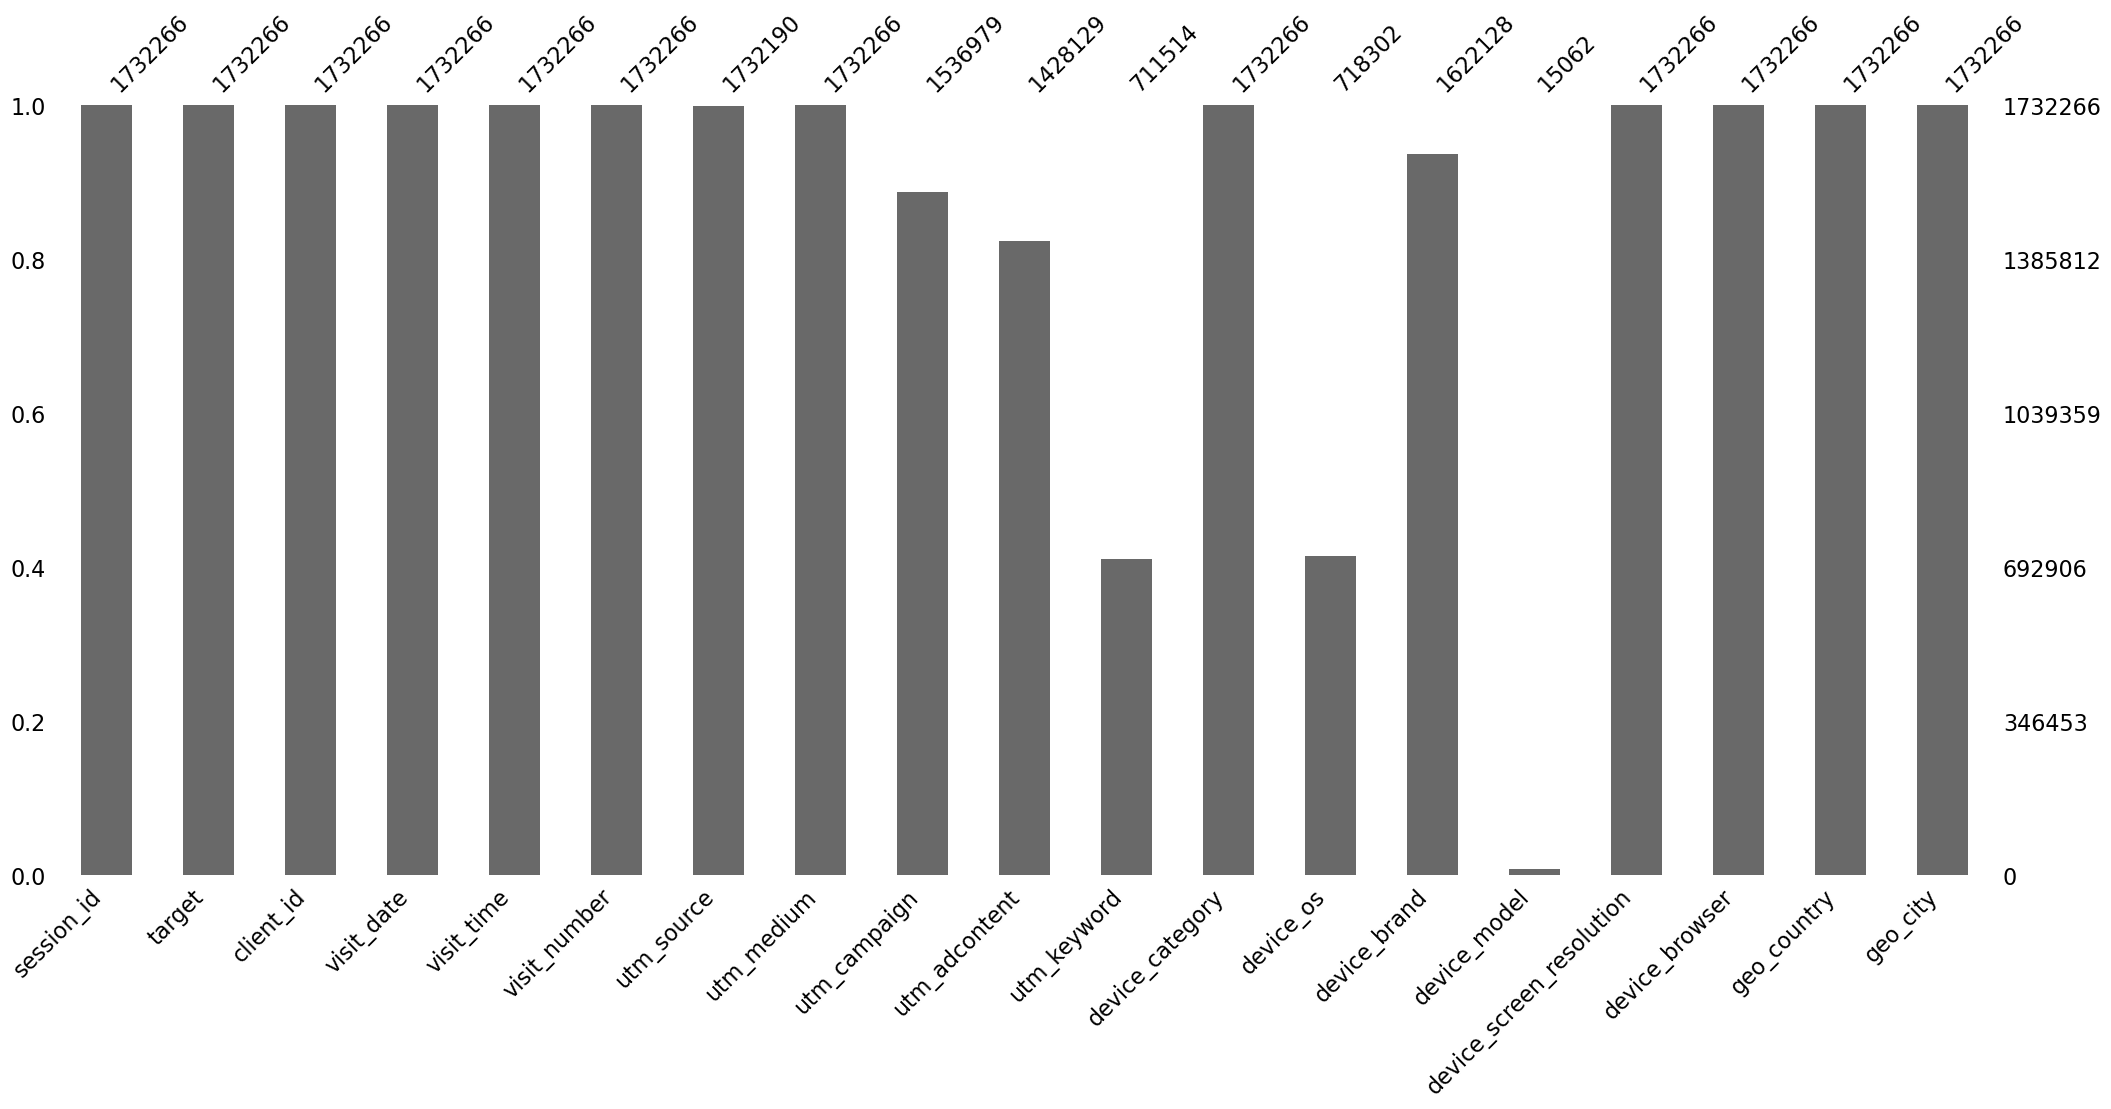

In [55]:
msno.bar(df_final);

In [27]:
df_final[df_final.duplicated()]

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city


In [130]:
df_final = df_final.drop(columns=['device_model', 'device_os', 'utm_keyword'])
df_final.head()

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,1000009318903347362.1632663668.1632663668,0,232832813.1632663714,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik
1,1000010177899156286.1635013443.1635013443,0,232833013.1635013438,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh
2,1000013386240115915.1635402956.1635402956,0,232833760.1635402955,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk
3,1000017303238376207.1623489300.1623489300,0,232834672.1623489295,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk
4,1000020580299877109.1624943350.1624943350,0,232835435.1624943349,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow


In [29]:
df_final.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    935408
NaN                     304137
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
LLfCasrxQzJIyuldcuWy     18138
TuyPWsGQruPMpKvRxeBF     17884
UxrnyMlRBSOhOjytXnMG     13349
dUuXlWzvmhDSyclWRhNP     10025
yYdBRbPmBMUZHXwqGxNx      9631
WYLajZgbUhGimwBKDZUH      8110
SOkCdPxfUcZUzzOdgGES      6671
nNqUcgFgcqQbTVSvgaHr      6000
AdeErYgVTbRcAWtHrMHq      5534
aYAcKhelKzYpXrRYknSP      4932
XKsYZiUFcdkUXQpoLKyS      3984
XSkXBCPfnJjvxbfeewtd      3800
xnyHaukLtAvgViiZSyBC      2496
SAVVWaMghGnnvPOqMOIt      2457
guyNoEvzgofQvvwExGOq      2161
LcGIUNPUAmXtQJaDfFBR      2026
qhEmhjPXvwgEHdBikgEQ      1675
NhvfEqcSTGEZKxxvUZlj      1545
DZYjhfIUfdqhfuTNUmjn      1423
EteMoEECGsaJeMnuvAZD      1369
sYzBROYhjSDbFZCpzGyf      1329
FkiRXDLOWtzVfvhEkhNo      1216
eOWmIGTKVDPewucDtZXG      1009
twlfGCnyRPFtCeUKaust       989
eEkLatVAYTkibdzPIyDi       845
ZKlsrASsGaoEHfwkdKjL       801
vIKILzdGQEEbEpgPefxF       769
WAeycgIq

In [131]:
df_final['utm_adcontent'] = df_final.utm_adcontent.fillna('other')
df_final.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    935408
other                   304137
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
LLfCasrxQzJIyuldcuWy     18138
TuyPWsGQruPMpKvRxeBF     17884
UxrnyMlRBSOhOjytXnMG     13349
dUuXlWzvmhDSyclWRhNP     10025
yYdBRbPmBMUZHXwqGxNx      9631
WYLajZgbUhGimwBKDZUH      8110
SOkCdPxfUcZUzzOdgGES      6671
nNqUcgFgcqQbTVSvgaHr      6000
AdeErYgVTbRcAWtHrMHq      5534
aYAcKhelKzYpXrRYknSP      4932
XKsYZiUFcdkUXQpoLKyS      3984
XSkXBCPfnJjvxbfeewtd      3800
xnyHaukLtAvgViiZSyBC      2496
SAVVWaMghGnnvPOqMOIt      2457
guyNoEvzgofQvvwExGOq      2161
LcGIUNPUAmXtQJaDfFBR      2026
qhEmhjPXvwgEHdBikgEQ      1675
NhvfEqcSTGEZKxxvUZlj      1545
DZYjhfIUfdqhfuTNUmjn      1423
EteMoEECGsaJeMnuvAZD      1369
sYzBROYhjSDbFZCpzGyf      1329
FkiRXDLOWtzVfvhEkhNo      1216
eOWmIGTKVDPewucDtZXG      1009
twlfGCnyRPFtCeUKaust       989
eEkLatVAYTkibdzPIyDi       845
ZKlsrASsGaoEHfwkdKjL       801
vIKILzdGQEEbEpgPefxF       769
WAeycgIq

In [63]:
df_final.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
NaN                     195287
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
sbJRYgVfvcnqKJNDDYIr     19942
okTXSMadDkjvntEHzIjp     18405
LwJZxKuWmvOhPsaCeRjG     16846
SgIUDYUKnyWHVowUOqid     15784
RoDitORHdzGfGhNCyEMy     15063
bxOTvPtyGSdUrbwoXCPO     14987
TmThBvoCcwkCZZUWACYq     14878
zxoiLxhuSIFrCeTLQVWZ     12234
bJJuEXRheRIxXEaYIXqM     11903
YCKgTzTDywjcWyQudGch     11735
nSReTmyFtbSjlPrTKoaX     11272
QEejXfOCtOMFLZqIPApp     10067
vRLTQQKAsFQMxbcHGPhu      9319
eimRuUrNhZLAYcwRrNXu      7724
jvsVVQVKRfBIqBDBuCkq      7721
VBmazutCflYumtDHrQYe      7280
MXqmDyetMTICSSitTjWV      6944
kVOrIKZFrEYGvixPclal      6894
QdLfySaGXolfTBSNVfHn      6845
PXQWdUxeUoXfoKzTBGpY      6829
KgicpPxiEQfzPlPwQZJq      6758
JwYIveaHVpeeRZloQCfF      6374
jqlUOdZBNZYfInQVcZlS      6248
WiILFRDQbcHDHNvHzGpX      5733
IKQsApKuPmZqqmhieEgf      5388
UvuMsOSDBWQGOIbDbXfV      5072
GWZGdHKP

In [132]:
df_final['utm_campaign'] = df_final.utm_campaign.fillna('other')
df_final.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
other                   195287
gecBYcKZCPMcVYdSSzKP    133247
XHNUiSKKGTEpSAlaVMFQ     23750
sbJRYgVfvcnqKJNDDYIr     19942
okTXSMadDkjvntEHzIjp     18405
LwJZxKuWmvOhPsaCeRjG     16846
SgIUDYUKnyWHVowUOqid     15784
RoDitORHdzGfGhNCyEMy     15063
bxOTvPtyGSdUrbwoXCPO     14987
TmThBvoCcwkCZZUWACYq     14878
zxoiLxhuSIFrCeTLQVWZ     12234
bJJuEXRheRIxXEaYIXqM     11903
YCKgTzTDywjcWyQudGch     11735
nSReTmyFtbSjlPrTKoaX     11272
QEejXfOCtOMFLZqIPApp     10067
vRLTQQKAsFQMxbcHGPhu      9319
eimRuUrNhZLAYcwRrNXu      7724
jvsVVQVKRfBIqBDBuCkq      7721
VBmazutCflYumtDHrQYe      7280
MXqmDyetMTICSSitTjWV      6944
kVOrIKZFrEYGvixPclal      6894
QdLfySaGXolfTBSNVfHn      6845
PXQWdUxeUoXfoKzTBGpY      6829
KgicpPxiEQfzPlPwQZJq      6758
JwYIveaHVpeeRZloQCfF      6374
jqlUOdZBNZYfInQVcZlS      6248
WiILFRDQbcHDHNvHzGpX      5733
IKQsApKuPmZqqmhieEgf      5388
UvuMsOSDBWQGOIbDbXfV      5072
GWZGdHKP

In [97]:
df_final.device_brand.value_counts(dropna=False)

Apple             503533
Samsung           311641
Xiaomi            269251
                  237058
Huawei            173828
None              110138
Realme             17926
(not set)          16392
OPPO               12775
Vivo               11026
OnePlus             9322
Asus                7487
Nokia               6864
Sony                6106
ZTE                 5987
Google              4472
Meizu               3529
Lenovo              2942
Blackview           2592
Tecno               2501
LG                  2256
Motorola            2189
BQ                  1466
itel                1031
Alcatel              901
DOOGEE               830
Oukitel              781
HTC                  735
Umidigi              636
Ulefone              481
Infinix              398
Vsmart               347
LeEco                326
BlackBerry           318
Cubot                301
Philips              284
Mozilla              276
POCO                 215
Sharp                214
Vertex               187


In [98]:
df_final.device_brand.unique()

array(['Samsung', 'Realme', 'Apple', 'Huawei', 'Xiaomi', None, 'Vivo', '',
       'OPPO', '(not set)', 'OnePlus', 'Sony', 'BQ', 'ZTE', 'Asus',
       'Umidigi', 'Meizu', 'itel', 'LG', 'LeEco', 'Nokia', 'Blackview',
       'Google', 'Lenovo', 'BlackBerry', 'Tecno', 'Cubot', 'Alcatel',
       'Neffos', 'Vsmart', 'Motorola', 'Infinix', 'TCL', 'Vertex',
       'Philips', 'Oukitel', 'Vernee', 'Micromax', 'HOMTOM', 'CAT',
       'Prestigio', 'Ulefone', 'Mozilla', 'DOOGEE', 'Leagoo', 'TP-Link',
       'SonyEricsson', 'HTC', 'Karbonn', 'Sharp', 'Wileyfox', 'POCO',
       'A1', 'Gionee', 'Coolpad', 'General Mobile', 'Digma',
       'Yota Devices', 'Gome', 'Haier', 'Egreat', 'Kata', 'Mito',
       'Poptel', 'Flylion', 'AGM', 'SenseIT', 'DEXP', 'Archos', 'Teclast',
       'Fly', 'MLS', 'Keecoo', 'InFocus', 'Highscreen', 'Panasonic',
       'Inoi', 'InnJoo', 'Iris', 'LeTV', 'Itoos', 'MTC', 'Black Fox',
       'Acer', 'Nuu', 'Celkon', 'Chuwi', 'Walton', 'Xiaolajiao',
       'Hisense', 'Lava', 'myPh

In [133]:
dictionary = {'(not set)': 'other', '': 'other' }
df_final = df_final.replace({'device_brand': dictionary})
df_final.device_brand = df_final.device_brand.fillna('other')

In [134]:
df_final.device_brand.value_counts(dropna=False)

Apple             503533
other             363588
Samsung           311641
Xiaomi            269251
Huawei            173828
Realme             17926
OPPO               12775
Vivo               11026
OnePlus             9322
Asus                7487
Nokia               6864
Sony                6106
ZTE                 5987
Google              4472
Meizu               3529
Lenovo              2942
Blackview           2592
Tecno               2501
LG                  2256
Motorola            2189
BQ                  1466
itel                1031
Alcatel              901
DOOGEE               830
Oukitel              781
HTC                  735
Umidigi              636
Ulefone              481
Infinix              398
Vsmart               347
LeEco                326
BlackBerry           318
Cubot                301
Philips              284
Mozilla              276
POCO                 215
Sharp                214
Vertex               187
TP-Link              186
DEXP                 184


In [117]:
df_final.utm_source.value_counts(dropna=False)

ZpYIoDJMcFzVoPFsHGJL    552555
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
bByPQxmDaMXgpHeypKSM     90356
QxAxdyPLuQMEcrdZWdWb     45267
aXQzDWsJuGXeBXexNHjc     29528
jaSOmLICuBzCFqHfBdRg     28288
RmEBuqrriAfAVsLQQmhk     27412
PlbkrSYoHuZBWfYjYnfw     20362
vFcAhRxLfOWKhvxjELkx     18320
hTjLvqNxGggkGnxSCaTm     14396
gDBGzjFKYabGgSPZvrDH     13331
fgymSoTvjKPEgaIJqsiH      9557
geDcueAOghDzHkGMmdOq      8180
ISrKoXQCxqqYvAZICvjs      7839
nSReTmyFtbSjlPrTKoaX      5815
eLzNJHzPelJpEyBwMrKo      4578
IZEXUFLARCUMynmHNBGo      4248
iNFgfQPqHPBuvGCYtrQE      3222
gVRrcxiDQubJiljoTbGm      2733
SzZERoLMmrEUEhDaYcyN      2648
oZCzWSykfixnjMPDNjSU      2585
nmfptFmSirEqNzAzqbXA      2197
GpAkIXsclxDGyILfNlrR      2071
TxKUcPpthBDPieTGmVhx      2024
ghoaGAksqhKomdFrxgyJ      1859
KgicpPxiEQfzPlPwQZJq      1674
nrKihqcWGIzDsOqljdAv      1514
DnEUulZAecfGPvdtZBYS      1386
BKeImrJuRDZcHiSSTdzm      1335
YlsczTIy

In [136]:
df_final.utm_source.mode()[0]

'ZpYIoDJMcFzVoPFsHGJL'

In [137]:
df_final.utm_source = df_final.utm_source.fillna(df_final.utm_source.mode()[0])

In [138]:
df_final.utm_source.value_counts(dropna=False)

ZpYIoDJMcFzVoPFsHGJL    552631
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
bByPQxmDaMXgpHeypKSM     90356
QxAxdyPLuQMEcrdZWdWb     45267
aXQzDWsJuGXeBXexNHjc     29528
jaSOmLICuBzCFqHfBdRg     28288
RmEBuqrriAfAVsLQQmhk     27412
PlbkrSYoHuZBWfYjYnfw     20362
vFcAhRxLfOWKhvxjELkx     18320
hTjLvqNxGggkGnxSCaTm     14396
gDBGzjFKYabGgSPZvrDH     13331
fgymSoTvjKPEgaIJqsiH      9557
geDcueAOghDzHkGMmdOq      8180
ISrKoXQCxqqYvAZICvjs      7839
nSReTmyFtbSjlPrTKoaX      5815
eLzNJHzPelJpEyBwMrKo      4578
IZEXUFLARCUMynmHNBGo      4248
iNFgfQPqHPBuvGCYtrQE      3222
gVRrcxiDQubJiljoTbGm      2733
SzZERoLMmrEUEhDaYcyN      2648
oZCzWSykfixnjMPDNjSU      2585
nmfptFmSirEqNzAzqbXA      2197
GpAkIXsclxDGyILfNlrR      2071
TxKUcPpthBDPieTGmVhx      2024
ghoaGAksqhKomdFrxgyJ      1859
KgicpPxiEQfzPlPwQZJq      1674
nrKihqcWGIzDsOqljdAv      1514
DnEUulZAecfGPvdtZBYS      1386
BKeImrJuRDZcHiSSTdzm      1335
YlsczTIy

In [139]:
missing_values2 = ((df_final.isna().sum() / len(df_final)) * 100).sort_values()

print('Процент пропущенных значений:')
missing_values2

Процент пропущенных значений:


session_id                  0.0
target                      0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64

In [140]:
with open('df_final2.pkl', 'wb') as file:
    pickle.dump(df_final, file)

In [4]:
with open('df_final2.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [5]:
df_final.head()

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,1000009318903347362.1632663668.1632663668,0,232832813.1632663714,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik
1,1000010177899156286.1635013443.1635013443,0,232833013.1635013438,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh
2,1000013386240115915.1635402956.1635402956,0,232833760.1635402955,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk
3,1000017303238376207.1623489300.1623489300,0,232834672.1623489295,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk
4,1000020580299877109.1624943350.1624943350,0,232835435.1624943349,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow


In [6]:
df_final.utm_medium.value_counts(dropna=False)

banner               525206
cpc                  399395
(none)               277060
cpm                  229791
referral             136851
organic               55009
email                 28287
push                  27710
stories               10472
cpv                    7815
blogger_channel        7731
smartbanner            6501
blogger_stories        4226
tg                     3920
cpa                    3266
post                   2227
outlook                1269
app                    1211
smm                    1194
clicks                  908
blogger_header          760
(not set)               405
info_text               335
sms                     194
landing                 127
partner                  95
link                     52
cbaafe                   43
CPM                      36
yandex_cpc               31
vk_smm                   25
static                   17
google_cpc               15
article                  15
web_polka                11
medium              

In [7]:
to_replace = {'(not set)': 'other', '(none)': 'other' }
df_final = df_final.replace({'utm_medium': to_replace})
df_final.head()

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,1000009318903347362.1632663668.1632663668,0,232832813.1632663714,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik
1,1000010177899156286.1635013443.1635013443,0,232833013.1635013438,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh
2,1000013386240115915.1635402956.1635402956,0,232833760.1635402955,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk
3,1000017303238376207.1623489300.1623489300,0,232834672.1623489295,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk
4,1000020580299877109.1624943350.1624943350,0,232835435.1624943349,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow


In [9]:
df_final.columns

Index(['session_id', 'target', 'client_id', 'visit_date', 'visit_time',
       'visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
       'utm_adcontent', 'device_category', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_country',
       'geo_city'],
      dtype='object')

In [11]:
df_final[['client_id', 'visit_date', 'visit_time',
                  'utm_source', 'utm_medium', 'utm_campaign',
                  'utm_adcontent', 'device_category', 'device_brand',
                  'device_screen_resolution', 'device_browser', 'geo_country',
                  'geo_city']].describe()

,client_id,visit_date,visit_time,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
count,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266,1732266
unique,1320704,226,85032,280,54,407,281,3,200,4947,55,159,2389
top,1750498477.1629450062,2021-05-24,13:00:00,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x896,Chrome,Russia,Moscow
freq,449,39230,58044,552631,525206,422992,935408,1368679,503533,155140,951573,1682423,750928


In [50]:
list_city = df_final.geo_city.unique().tolist()
to_replace = {city: 'other' for city in list_city if not city[0].isupper()}
df_final = df_final.replace({'geo_city': to_replace})

In [51]:
df_final.geo_city.value_counts()

Moscow                          750928
Saint Petersburg                278402
other                            73592
Yekaterinburg                    33555
Krasnodar                        30260
Kazan                            27689
Samara                           23433
Nizhny Novgorod                  20782
Ufa                              20283
Novosibirsk                      20115
Krasnoyarsk                      15283
Chelyabinsk                      14923
Tula                             14774
Rostov-on-Don                    13064
Voronezh                         12701
Irkutsk                          12596
Grozny                           11949
Balashikha                       11868
Vladivostok                      11514
Yaroslavl                         9143
Sochi                             8402
Tyumen                            7898
Khimki                            6849
Saratov                           6661
Perm                              5911
Vidnoye                  

In [52]:
to_replace1 = {'(not set)': 'other'}
df_final = df_final.replace({'geo_country': to_replace1})
df_final.geo_country.value_counts()

Russia                      1682423
Ukraine                        8455
United States                  8141
Belarus                        3432
Kazakhstan                     2109
Germany                        2085
Ireland                        1989
Turkey                         1787
Sweden                         1731
Netherlands                    1451
Uzbekistan                     1422
United Kingdom                 1371
other                          1071
Kyrgyzstan                      926
Georgia                         881
France                          742
Cyprus                          706
Armenia                         629
Finland                         610
Spain                           548
Poland                          490
United Arab Emirates            440
Israel                          399
Moldova                         368
Tajikistan                      367
Latvia                          332
Italy                           316
Azerbaijan                  

In [53]:
df_final['visit_date'].values.tolist()

[datetime.date(2021, 9, 26),
 datetime.date(2021, 10, 23),
 datetime.date(2021, 10, 28),
 datetime.date(2021, 6, 12),
 datetime.date(2021, 6, 29),
 datetime.date(2021, 6, 29),
 datetime.date(2021, 5, 29),
 datetime.date(2021, 5, 29),
 datetime.date(2021, 12, 11),
 datetime.date(2021, 10, 9),
 datetime.date(2021, 11, 29),
 datetime.date(2021, 12, 6),
 datetime.date(2021, 11, 9),
 datetime.date(2021, 12, 11),
 datetime.date(2021, 12, 11),
 datetime.date(2021, 12, 31),
 datetime.date(2021, 11, 29),
 datetime.date(2021, 12, 5),
 datetime.date(2021, 12, 26),
 datetime.date(2021, 6, 28),
 datetime.date(2021, 12, 1),
 datetime.date(2021, 9, 14),
 datetime.date(2021, 10, 29),
 datetime.date(2021, 12, 26),
 datetime.date(2021, 12, 26),
 datetime.date(2021, 5, 24),
 datetime.date(2021, 10, 3),
 datetime.date(2021, 12, 5),
 datetime.date(2021, 9, 8),
 datetime.date(2021, 6, 22),
 datetime.date(2021, 6, 22),
 datetime.date(2021, 12, 19),
 datetime.date(2021, 12, 19),
 datetime.date(2021, 12, 22),


In [54]:
df_final['visit_time'].values.tolist()

[datetime.time(16, 0),
 datetime.time(21, 24, 3),
 datetime.time(9, 35, 56),
 datetime.time(12, 0),
 datetime.time(8, 0),
 datetime.time(18, 0),
 datetime.time(1, 0),
 datetime.time(15, 0),
 datetime.time(6, 37, 2),
 datetime.time(20, 0),
 datetime.time(14, 47, 4),
 datetime.time(13, 28, 50),
 datetime.time(8, 45, 43),
 datetime.time(14, 0, 33),
 datetime.time(14, 1, 31),
 datetime.time(22, 17, 3),
 datetime.time(12, 2, 55),
 datetime.time(12, 8, 35),
 datetime.time(16, 12, 9),
 datetime.time(22, 0),
 datetime.time(11, 7, 53),
 datetime.time(19, 0),
 datetime.time(20, 41, 45),
 datetime.time(16, 51, 37),
 datetime.time(17, 33, 24),
 datetime.time(18, 0),
 datetime.time(18, 0),
 datetime.time(7, 2, 17),
 datetime.time(3, 0),
 datetime.time(20, 0),
 datetime.time(20, 0),
 datetime.time(9, 57, 43),
 datetime.time(14, 52, 24),
 datetime.time(15, 2, 25),
 datetime.time(14, 0),
 datetime.time(13, 45, 5),
 datetime.time(13, 38, 18),
 datetime.time(23, 0),
 datetime.time(19, 32, 49),
 datetime

In [58]:
df_final.head()

,session_id,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,1000009318903347362.1632663668.1632663668,0,232832813.1632663714,2021-09-26,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik
1,1000010177899156286.1635013443.1635013443,0,232833013.1635013438,2021-10-23,21:24:03,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh
2,1000013386240115915.1635402956.1635402956,0,232833760.1635402955,2021-10-28,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk
3,1000017303238376207.1623489300.1623489300,0,232834672.1623489295,2021-06-12,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk
4,1000020580299877109.1624943350.1624943350,0,232835435.1624943349,2021-06-29,08:00:00,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow


In [61]:
#df_hits_cut['target'] = df_hits_cut.apply(lambda x: 1 if x.event_action in targets else 0, axis=1)
df_final['date'] = df_final['visit_date'].astype(str) + ' ' + df_final['visit_time'].astype(str)

In [66]:
df_final.date = pd.to_datetime(df_final['date'], utc=True)
df_final.dtypes

session_id                               object
target                                    int64
client_id                                object
visit_date                               object
visit_time                               object
visit_number                              int64
utm_source                               object
utm_medium                               object
utm_campaign                             object
utm_adcontent                            object
device_category                          object
device_brand                             object
device_screen_resolution                 object
device_browser                           object
geo_country                              object
geo_city                                 object
date                        datetime64[ns, UTC]
dtype: object

In [69]:
df_final = df_final.drop(columns=['visit_date', 'visit_time'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 15 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   session_id                object             
 1   target                    int64              
 2   client_id                 object             
 3   visit_number              int64              
 4   utm_source                object             
 5   utm_medium                object             
 6   utm_campaign              object             
 7   utm_adcontent             object             
 8   device_category           object             
 9   device_brand              object             
 10  device_screen_resolution  object             
 11  device_browser            object             
 12  geo_country               object             
 13  geo_city                  object             
 14  date                      datetime64[ns, UTC]
dtypes: datetime64[n

In [70]:
with open('df_final2.pkl', 'wb') as file:
    pickle.dump(df_final, file)

In [3]:
with open('df_final2.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [4]:
df_final['month'] = [df_final.date[d].month for d in range(0,len(df_final))]
df_final['day'] = [df_final.date[d].day for d in range(0,len(df_final))]
df_final['hour'] = [df_final.date[d].hour for d in range(0,len(df_final))]

In [5]:
df_final.head()

,session_id,target,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,date,month,day,hour
0,1000009318903347362.1632663668.1632663668,0,232832813.1632663714,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik,2021-09-26 16:00:00+00:00,9,26,16
1,1000010177899156286.1635013443.1635013443,0,232833013.1635013438,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh,2021-10-23 21:24:03+00:00,10,23,21
2,1000013386240115915.1635402956.1635402956,0,232833760.1635402955,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk,2021-10-28 09:35:56+00:00,10,28,9
3,1000017303238376207.1623489300.1623489300,0,232834672.1623489295,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk,2021-06-12 12:00:00+00:00,6,12,12
4,1000020580299877109.1624943350.1624943350,0,232835435.1624943349,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow,2021-06-29 08:00:00+00:00,6,29,8


In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 18 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   session_id                object             
 1   target                    int64              
 2   client_id                 object             
 3   visit_number              int64              
 4   utm_source                object             
 5   utm_medium                object             
 6   utm_campaign              object             
 7   utm_adcontent             object             
 8   device_category           object             
 9   device_brand              object             
 10  device_screen_resolution  object             
 11  device_browser            object             
 12  geo_country               object             
 13  geo_city                  object             
 14  date                      datetime64[ns, UTC]
 15  month          

In [7]:
df_final.corr()

,target,visit_number,month,day,hour
target,1.000000,0.027947,-0.051364,-0.000816,0.000104
visit_number,0.027947,1.000000,0.012155,-0.010830,0.004726
month,-0.051364,0.012155,1.000000,-0.160011,0.024600
day,-0.000816,-0.010830,-0.160011,1.000000,-0.005299
hour,0.000104,0.004726,0.024600,-0.005299,1.000000


In [8]:
df_final = df_final.drop(columns=['hour','date','client_id','session_id'])

In [9]:
with open('df_final3.pkl', 'wb') as file:
    pickle.dump(df_final, file)

## 3.Data preparation-2

In [34]:
with open('df_final3.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [46]:
# Удалим все строки не из России

In [36]:
df_final = df_final.copy()
df_final = df_final[df_final.geo_country == 'Russia']

In [47]:
# Все города, число которых меньше 100, переименуем в other

In [45]:
list_city = [city for city in df_final.geo_city.unique() if df_final.geo_city.value_counts()[city] < 100]
list_city

['Novoaltaysk',
 'Glazov',
 'Vyshny Volochyok',
 'Elektrougli',
 'Udomlya',
 'Pushchino',
 'Neryungri',
 'Plastunovskaya',
 'Satka',
 'Bataysk',
 'Naryan-Mar',
 'Nadym',
 'Verkhnyaya Salda',
 'Maloyaroslavets',
 'Zarechnyy',
 'Kandalaksha',
 'Yeysk',
 'Kamensk-Shakhtinsky',
 'Torzhok',
 'Lysva',
 'Mozhga',
 'Nizhnyaya Tura',
 'Rostov',
 'Nyagan',
 'Poronaysk',
 'Shadrinsk',
 'Oktyabrsky',
 'Borisoglebsk',
 'Mirny',
 'Pyt-Yakh',
 'Yelets',
 'Yuzhnouralsk',
 'Noyabrsk',
 'Polevskoy',
 'Otradny',
 'Kyshtym',
 'Lesnoy Gorodok',
 'Neftekamsk',
 'Balakhna',
 'Kumertau',
 'Mineralnye Vody',
 'Shakhovskaya',
 'Monchegorsk',
 'Seversk',
 'Shelekhov',
 'Kizilyurt',
 'Chistopol',
 'Kansk',
 'Inta',
 'Gus-Khrustalny',
 'Tikhoretsk',
 'Novoshakhtinsk',
 'Elektrogorsk',
 'Serov',
 'Buynaksk',
 'Arsenyev',
 'Orsk',
 'Kartaly',
 'Kurovskoye',
 'Kuznetsk',
 'Rossosh',
 'Dubovoe',
 'Kropotkin',
 'Samarskoye',
 'Kurchatov',
 'Svetogorsk',
 'Yurga',
 'Pavlovo',
 'Tynda',
 'Kanevskaya',
 'Zarinsk',
 'Megio

In [48]:
df_final = df_final.copy()
to_replace = {city: 'other' for city in list_city}
df_final = df_final.replace({'geo_city': to_replace})
df_final.geo_city.value_counts()

Moscow                       750928
Saint Petersburg             278402
other                         72734
Yekaterinburg                 33555
Krasnodar                     30260
Kazan                         27689
Samara                        23433
Nizhny Novgorod               20782
Ufa                           20283
Novosibirsk                   20115
Krasnoyarsk                   15283
Chelyabinsk                   14923
Tula                          14774
Rostov-on-Don                 13064
Voronezh                      12701
Irkutsk                       12596
Grozny                        11949
Balashikha                    11868
Vladivostok                   11514
Yaroslavl                      9143
Sochi                          8402
Tyumen                         7898
Khimki                         6849
Saratov                        6661
Perm                           5911
Vidnoye                        5058
Odintsovo                      4979
Mytishchi                   

In [ ]:
# все браузеры, число которых меньше 1000, переименуем в other

In [50]:
list_browser = [bro for bro in df_final.device_browser.unique() if df_final.device_browser.value_counts()[bro] < 1000]
df_final = df_final.copy()
to_replace = {bro: 'other' for bro in list_browser}
df_final = df_final.replace({'device_browser': to_replace})
df_final.device_browser.value_counts(dropna=False)

Chrome              927284
Safari              421572
YaBrowser           122069
Safari (in-app)      63075
Android Webview      49837
Samsung Internet     43515
Opera                24248
Firefox              14974
Edge                 14584
other                 1265
Name: device_browser, dtype: int64

In [52]:
# если разрешение экрана встречается меньше 1000 раз, то переименуем в other

In [53]:
list_screen = [sc for sc in df_final.device_screen_resolution.unique() if df_final.device_screen_resolution.value_counts()[sc] < 1000]
df_final = df_final.copy()
to_replace = {sc: 'other' for sc in list_screen}
df_final = df_final.replace({'device_screen_resolution': to_replace})
df_final.device_screen_resolution.value_counts(dropna=False)

414x896      151159
1920x1080    116181
393x851      105899
375x812      103253
360x780       85577
375x667       84095
360x800       74003
412x915       69088
other         66673
360x640       64421
390x844       53313
393x873       47674
360x760       46632
360x720       46594
412x892       40887
428x926       35529
1536x864      34194
1366x768      30663
414x736       29542
1440x900      28542
412x846       23212
412x869       22701
320x568       20984
360x740       20359
1280x720      18704
385x854       17594
384x854       14153
2560x1440     12338
1600x900      11859
393x786       11679
1680x1050     10375
320x694       10304
360x771        8404
1280x1024      7424
768x1024       7314
320x640        7244
1792x1120      7162
412x732        6816
1280x800       6660
851x393        6518
320x712        5363
1920x1200      5236
320x676        4816
424x918        4504
393x830        4463
320x569        4210
360x770        3783
800x360        3715
320x693        3493
780x360        3253


In [54]:
with open('df_final4.pkl', 'wb') as file:
    pickle.dump(df_final, file)

In [56]:
# если брэнд встречается меньше 1000 раз, то переименуем в other

In [57]:
list_brand = [db for db in df_final.device_brand.unique() if df_final.device_brand.value_counts()[db] < 1000]

In [58]:
df_final = df_final.copy()
to_replace = {db: 'other' for db in list_brand}
df_final = df_final.replace({'device_brand': to_replace})
df_final.device_brand.value_counts(dropna=False)

Apple        485590
other        359208
Samsung      304610
Xiaomi       263539
Huawei       171091
Realme        17726
OPPO          12522
Vivo          10924
OnePlus        9018
Asus           7410
Nokia          6752
Sony           5950
ZTE            5949
Google         3928
Meizu          3473
Lenovo         2891
Blackview      2570
Tecno          2462
LG             2206
Motorola       2134
BQ             1446
itel           1024
Name: device_brand, dtype: int64

In [61]:
# если кол-во utm_adcontent < 1000, то переименуем в other

In [62]:
list_utm_adcontent = [adb for adb in df_final.utm_adcontent.unique() if df_final.utm_adcontent.value_counts()[adb] < 1000]

In [63]:
df_final = df_final.copy()
to_replace = {adb: 'other' for adb in list_utm_adcontent}
df_final = df_final.replace({'utm_adcontent': to_replace})
df_final.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    903794
other                   314470
vCIpmpaGBnIQhyYNkXqp    176189
xhoenQgDQsgfEPYNPwKO    103567
PkybGvWbaqORmxjNunqZ     58808
LLfCasrxQzJIyuldcuWy     17962
TuyPWsGQruPMpKvRxeBF     17858
UxrnyMlRBSOhOjytXnMG     13221
dUuXlWzvmhDSyclWRhNP      9991
yYdBRbPmBMUZHXwqGxNx      9618
WYLajZgbUhGimwBKDZUH      8020
SOkCdPxfUcZUzzOdgGES      6623
nNqUcgFgcqQbTVSvgaHr      5957
AdeErYgVTbRcAWtHrMHq      5514
aYAcKhelKzYpXrRYknSP      4871
XKsYZiUFcdkUXQpoLKyS      3970
XSkXBCPfnJjvxbfeewtd      3714
xnyHaukLtAvgViiZSyBC      2488
SAVVWaMghGnnvPOqMOIt      2410
guyNoEvzgofQvvwExGOq      2149
LcGIUNPUAmXtQJaDfFBR      2025
qhEmhjPXvwgEHdBikgEQ      1631
NhvfEqcSTGEZKxxvUZlj      1387
EteMoEECGsaJeMnuvAZD      1339
sYzBROYhjSDbFZCpzGyf      1322
DZYjhfIUfdqhfuTNUmjn      1319
FkiRXDLOWtzVfvhEkhNo      1206
eOWmIGTKVDPewucDtZXG      1000
Name: utm_adcontent, dtype: int64

In [ ]:
# Если кол-во utm_campaign < 1000, то переименуем в other

In [65]:
list_utm_campaign = [cpg for cpg in df_final.utm_campaign.unique() if df_final.utm_campaign.value_counts()[cpg] < 1000]

In [66]:
df_final = df_final.copy()
to_replace = {cpg: 'other' for cpg in list_utm_campaign}
df_final = df_final.replace({'utm_campaign': to_replace})
df_final.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    403634
LEoPHuyFvzoNfnzGgfcd    316217
FTjNLDyTrXaWYgZymFkV    233255
other                   231978
gecBYcKZCPMcVYdSSzKP    131540
XHNUiSKKGTEpSAlaVMFQ     23028
sbJRYgVfvcnqKJNDDYIr     19401
okTXSMadDkjvntEHzIjp     18226
LwJZxKuWmvOhPsaCeRjG     16185
SgIUDYUKnyWHVowUOqid     15343
TmThBvoCcwkCZZUWACYq     14602
RoDitORHdzGfGhNCyEMy     14579
bxOTvPtyGSdUrbwoXCPO     14447
zxoiLxhuSIFrCeTLQVWZ     11996
YCKgTzTDywjcWyQudGch     11661
bJJuEXRheRIxXEaYIXqM     11502
nSReTmyFtbSjlPrTKoaX     10751
QEejXfOCtOMFLZqIPApp      8943
vRLTQQKAsFQMxbcHGPhu      8877
jvsVVQVKRfBIqBDBuCkq      7630
eimRuUrNhZLAYcwRrNXu      7601
VBmazutCflYumtDHrQYe      7175
MXqmDyetMTICSSitTjWV      6822
QdLfySaGXolfTBSNVfHn      6795
kVOrIKZFrEYGvixPclal      6783
KgicpPxiEQfzPlPwQZJq      6664
PXQWdUxeUoXfoKzTBGpY      6641
JwYIveaHVpeeRZloQCfF      6283
jqlUOdZBNZYfInQVcZlS      6114
WiILFRDQbcHDHNvHzGpX      5634
IKQsApKuPmZqqmhieEgf      5249
UvuMsOSDBWQGOIbDbXfV      4988
vXsFkagG

In [68]:
# Если кол-во utm_medium < 10, то это понты , ребят

In [69]:
list_utm_medium = [med for med in df_final.utm_medium.unique() if df_final.utm_medium.value_counts()[med] < 10]
df_final = df_final.copy()
to_replace = {med: 'other' for med in list_utm_medium}
df_final = df_final.replace({'utm_medium': to_replace})
df_final.utm_medium.value_counts(dropna=False)

banner             516977
cpc                385557
other              263496
cpm                227981
referral           132442
organic             53341
email               27544
push                27025
stories              9262
cpv                  7785
blogger_channel      6572
smartbanner          6356
blogger_stories      3881
tg                   3681
cpa                  2609
post                 2061
app                  1201
outlook              1201
smm                  1163
clicks                866
blogger_header        491
info_text             326
sms                   189
landing               127
partner                94
link                   50
CPM                    36
yandex_cpc             31
vk_smm                 23
static                 16
article                15
google_cpc             13
web_polka              11
Name: utm_medium, dtype: int64

In [71]:
# меньше 1000 на other

In [72]:
list_utm_source = [sou for sou in df_final.utm_source.unique() if df_final.utm_source.value_counts()[sou] < 1000]

In [73]:
df_final = df_final.copy()
to_replace = {sou: 'other' for sou in list_utm_source}
df_final = df_final.replace({'utm_source': to_replace})
df_final.utm_source.value_counts(dropna=False)

ZpYIoDJMcFzVoPFsHGJL    543692
fDLlAcSmythWSCVMvqvL    263041
kjsLglQLzykiRbcDiGcD    238131
MvfHsxITijuriZxsqZqt    174092
BHcvLfOaCWvWTykYqHVe    109057
bByPQxmDaMXgpHeypKSM     87439
QxAxdyPLuQMEcrdZWdWb     38634
aXQzDWsJuGXeBXexNHjc     28942
jaSOmLICuBzCFqHfBdRg     27545
RmEBuqrriAfAVsLQQmhk     27021
PlbkrSYoHuZBWfYjYnfw     20286
vFcAhRxLfOWKhvxjELkx     18142
other                    13576
gDBGzjFKYabGgSPZvrDH     13203
hTjLvqNxGggkGnxSCaTm     12947
fgymSoTvjKPEgaIJqsiH      9544
geDcueAOghDzHkGMmdOq      8090
ISrKoXQCxqqYvAZICvjs      7106
nSReTmyFtbSjlPrTKoaX      5670
eLzNJHzPelJpEyBwMrKo      4563
IZEXUFLARCUMynmHNBGo      3763
iNFgfQPqHPBuvGCYtrQE      3148
gVRrcxiDQubJiljoTbGm      2649
SzZERoLMmrEUEhDaYcyN      2604
oZCzWSykfixnjMPDNjSU      2520
nmfptFmSirEqNzAzqbXA      2189
GpAkIXsclxDGyILfNlrR      2041
TxKUcPpthBDPieTGmVhx      2023
KgicpPxiEQfzPlPwQZJq      1642
ghoaGAksqhKomdFrxgyJ      1569
nrKihqcWGIzDsOqljdAv      1502
DnEUulZAecfGPvdtZBYS      1328
BKeImrJu

In [74]:
with open('df_final4.pkl', 'wb') as file:
    pickle.dump(df_final, file)

In [13]:
with open('df_final4.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [ ]:
# Оказалось, что в visit_number много выбросов изза чего модель не обучается нормально. Исправим

In [14]:
df_final.visit_number.describe().apply(lambda x: f'{x:0.3f}')

count    1682423.000
mean           2.654
std           11.795
min            1.000
25%            1.000
50%            1.000
75%            1.000
max          564.000
Name: visit_number, dtype: object

In [20]:
df_final.visit_number.value_counts(dropna=False)

1      1261938
2       206508
3        69990
4        35678
5        20940
6        14182
7        10095
8         7542
9         5788
10        4701
11        3852
12        3195
13        2709
14        2294
15        2021
16        1753
17        1552
18        1389
19        1209
20        1099
21        1013
22         918
23         831
24         761
25         720
26         651
27         595
28         553
29         505
30         487
31         461
32         438
33         416
34         387
35         375
36         351
38         335
37         330
39         301
40         291
41         281
42         271
43         262
44         260
46         251
45         238
47         225
48         223
49         213
50         208
51         208
52         192
53         189
55         186
54         181
56         180
58         177
57         165
61         163
59         162
60         162
62         153
63         152
67         143
64         143
65         139
66        

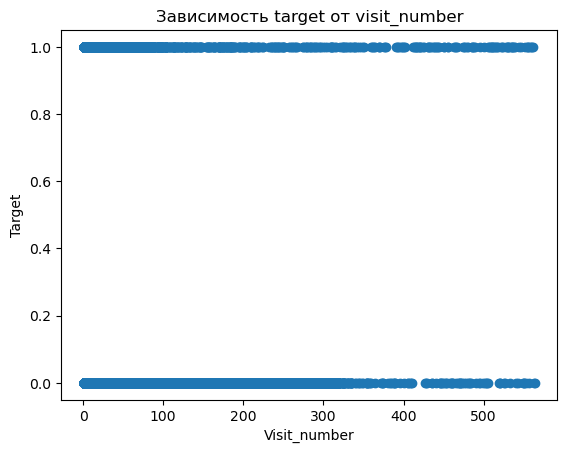

In [22]:
plt.figure()
plt.scatter(df_final.visit_number, df_final.target)
plt.title("Зависимость target от visit_number")
plt.xlabel('Visit_number')
plt.ylabel('Target')

plt.show();

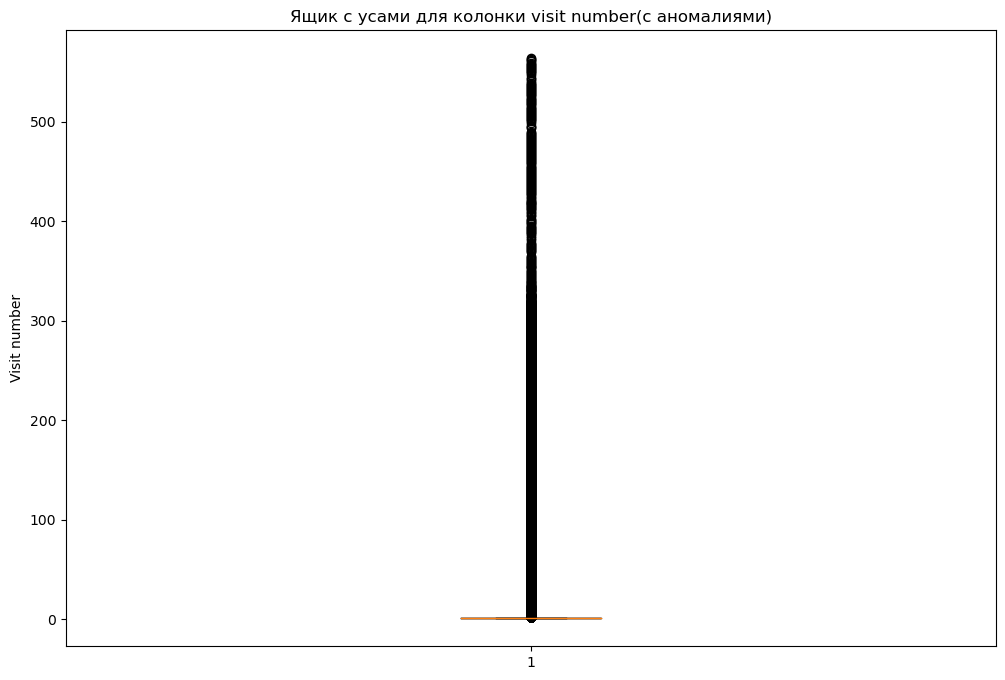

In [18]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df_final.visit_number)
ax.set_ylabel('Visit number')
ax.set_title('Ящик с усами для колонки visit number(с аномалиями)')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [28]:
list_visit_number = [vn for vn in df_final.visit_number.unique() if vn > 3]
df_final = df_final.copy()
to_replace = {vn: 3 for vn in list_visit_number}
df_final = df_final.replace({'visit_number': to_replace})
df_final.visit_number.value_counts(dropna=False)

1    1261938
3     213977
2     206508
Name: visit_number, dtype: int64

In [29]:
df_final.visit_number.describe().apply(lambda x: f'{x:0.3f}')

count    1682423.000
mean           1.377
std            0.699
min            1.000
25%            1.000
50%            1.000
75%            1.000
max            3.000
Name: visit_number, dtype: object

In [30]:
with open('df_final4.pkl', 'wb') as file:
    pickle.dump(df_final, file)

In [3]:
with open('df_final4.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [4]:
df_final.head()

,target,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,month,day
0,0,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik,9,26
1,0,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh,10,23
2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk,10,28
3,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk,6,12
4,0,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow,6,29


In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682423 entries, 0 to 1732265
Data columns (total 14 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   target                    1682423 non-null  int64 
 1   visit_number              1682423 non-null  int64 
 2   utm_source                1682423 non-null  object
 3   utm_medium                1682423 non-null  object
 4   utm_campaign              1682423 non-null  object
 5   utm_adcontent             1682423 non-null  object
 6   device_category           1682423 non-null  object
 7   device_brand              1682423 non-null  object
 8   device_screen_resolution  1682423 non-null  object
 9   device_browser            1682423 non-null  object
 10  geo_country               1682423 non-null  object
 11  geo_city                  1682423 non-null  object
 12  month                     1682423 non-null  int64 
 13  day                       1682423 non-null

In [6]:
df_final[df_final.utm_source.isna()].head()

,target,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,month,day


## 4.Feature_engineering

In [3]:
with open('df_final4.pkl', 'rb') as file:
    df_final = pickle.load(file)

In [4]:
df_final.head()

,target,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,month,day
0,0,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,Samsung,412x869,Chrome,Russia,Gelendzhik,9,26
1,0,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Samsung Internet,Russia,Voronezh,10,23
2,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,412x846,Chrome,Russia,Cherkessk,10,28
3,0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Realme,360x780,Chrome,Russia,Irkutsk,6,12
4,0,1,fDLlAcSmythWSCVMvqvL,other,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,414x736,Safari,Russia,Moscow,6,29


In [5]:
std_scaler = StandardScaler()
std_scaler.fit(df_final[['visit_number', 'month', 'day']])
std_scaled = std_scaler.transform(df_final[['visit_number', 'month', 'day']])
df_final[['std_scaled_visit_number', 'std_scaled_month', 'std_scaled_day']] = std_scaled

In [6]:
df_final = df_final.drop(columns=['geo_country'])

In [7]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_final[['utm_source','utm_medium','utm_campaign','utm_adcontent','device_category','device_brand',
                  'device_screen_resolution','device_browser','geo_city']])
ohe_matrix = ohe.transform(df_final[['utm_source','utm_medium','utm_campaign','utm_adcontent',
                                     'device_category','device_brand','device_screen_resolution',
                                     'device_browser','geo_city']])

In [8]:
df_matrix = pd.DataFrame(ohe_matrix, columns=ohe.get_feature_names_out())

In [9]:
df_matrix.shape

(1682423, 555)

In [10]:
df_final.shape

(1682423, 16)

In [11]:
df_final_2 = pd.merge(left=df_final, right=df_matrix, on=df_final.index, how='outer')

In [12]:
df_final_2.shape

(1682423, 572)

In [13]:
df_final_2 = df_final_2.drop(columns=['key_0','utm_source','utm_medium','utm_campaign','utm_adcontent','device_category','device_brand',
                  'device_screen_resolution','device_browser','geo_city','visit_number', 'month', 'day'])

In [14]:
df_final_2.head()

,target,std_scaled_visit_number,std_scaled_month,std_scaled_day,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_GpAkIXsclxDGyILfNlrR,utm_source_ISrKoXQCxqqYvAZICvjs,utm_source_IZEXUFLARCUMynmHNBGo,...,geo_city_Yoshkar-Ola,geo_city_Yuzhno-Sakhalinsk,geo_city_Zagorjanskas,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zvenigorod,geo_city_other,geo_city_Хомутово
0,0,-0.539135,-0.128514,1.013289,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.539135,0.324177,0.671740,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-0.539135,0.324177,1.240988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-0.539135,-1.486587,-0.580606,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-0.539135,-1.486587,1.354838,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_final_2.std_scaled_visit_number.value_counts(dropna=False)

-0.539135    1261938
 2.320149     213977
 0.890507     206508
Name: std_scaled_visit_number, dtype: int64

In [38]:
df_final_2.head()

,target,std_scaled_visit_number,std_scaled_month,std_scaled_day,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_GpAkIXsclxDGyILfNlrR,utm_source_ISrKoXQCxqqYvAZICvjs,utm_source_IZEXUFLARCUMynmHNBGo,...,geo_city_Yoshkar-Ola,geo_city_Yuzhno-Sakhalinsk,geo_city_Zagorjanskas,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zvenigorod,geo_city_other,geo_city_Хомутово
0,0,-0.539135,-0.128514,1.013289,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.539135,0.324177,0.671740,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-0.539135,0.324177,1.240988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,-0.539135,-1.486587,-0.580606,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-0.539135,-1.486587,1.354838,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('df_final5.pkl', 'wb') as file:
    pickle.dump(df_final_2, file)

## 5.Modeling

In [2]:
%%time
with open('df_final5.pkl', 'rb') as file:
    df_final = pickle.load(file)

Wall time: 13.8 s


In [4]:
#в рез-тате экспериментов установил, что модели лучше обучаются, если кол-во target==1 и 
#target==0 находятся в соотношении 2 к 1
df_target1 = df_final[df_final.target == 1]
df_target0 = df_final[df_final.target == 0]
df_target0_sample = df_target0.sample(n=len(df_target1)*2, replace=False)

In [6]:
df = pd.concat([df_target0_sample, df_target1], axis=0)
print(df.shape)
df.head()

(147468, 559)


,target,std_scaled_visit_number,std_scaled_month,std_scaled_day,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_GpAkIXsclxDGyILfNlrR,utm_source_ISrKoXQCxqqYvAZICvjs,utm_source_IZEXUFLARCUMynmHNBGo,...,geo_city_Yoshkar-Ola,geo_city_Yuzhno-Sakhalinsk,geo_city_Zagorjanskas,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zvenigorod,geo_city_other,geo_city_Хомутово
1239344,0,0.890507,-0.581205,-1.719103,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1355143,0,-0.539135,-0.581205,-1.377554,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1568821,0,2.320149,-0.128514,-0.011358,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564812,0,0.890507,1.229559,0.785590,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
737054,0,-0.539135,0.776868,0.102492,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
x = df.drop(columns=['target'], axis=1)
y = df.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### 1.LogisticRegression

In [12]:
logreg = LogisticRegression(solver='liblinear', C=1, random_state=42, max_iter=2000)
logreg.fit(x_train, y_train)

LogisticRegression(C=1, max_iter=2000, random_state=42, solver='liblinear')

In [14]:
logreg_pred = logreg.predict(x_test)
print(logreg.score(x_train, y_train))
print(accuracy_score(y_test, logreg_pred))
print(confusion_matrix(y_test, logreg_pred))
print(mean_absolute_error(y_test, logreg_pred))

0.691447005144003
0.6903777039397844
[[27090  2402]
 [11296  3453]]
0.30962229606021563


In [16]:
preds = logreg.predict_proba(x_test)
logreg_probs = preds[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_probs)
print('LR: ROC AUC=%.3f' % (logreg_auc))

LR: ROC AUC=0.691


In [17]:
cross_val_score(logreg, x, y, cv=4)

array([0.68961402, 0.68698294, 0.68888166, 0.68733556])

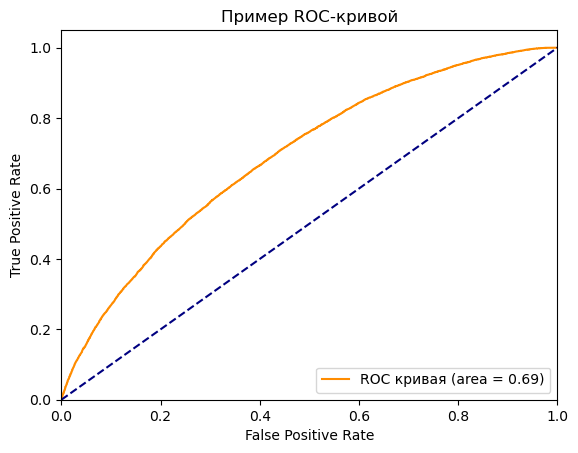

In [18]:
fpr, tpr, treshold = roc_curve(y_test, logreg_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right");

#### 2.RandomForestClassifier

In [20]:
rf = RandomForestClassifier(random_state=42, max_features='sqrt', min_samples_leaf=2, n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, random_state=42)

In [22]:
rf_preds = rf.predict(x_test)
print(rf.score(x_train, y_train))
print(accuracy_score(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))
print(mean_absolute_error(y_test, rf_preds))

0.7370552277989286
0.6972717614882122
[[27524  1968]
 [11425  3324]]
0.3027282385117877


In [23]:
preds = rf.predict_proba(x_test)
rf_probs = preds[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
print('Tree: ROC AUC=%.3f' % (rf_auc))

Tree: ROC AUC=0.709


In [25]:
cross_val_score(rf, x, y, cv=4)

array([0.69284184, 0.69153986, 0.69259772, 0.68958689])

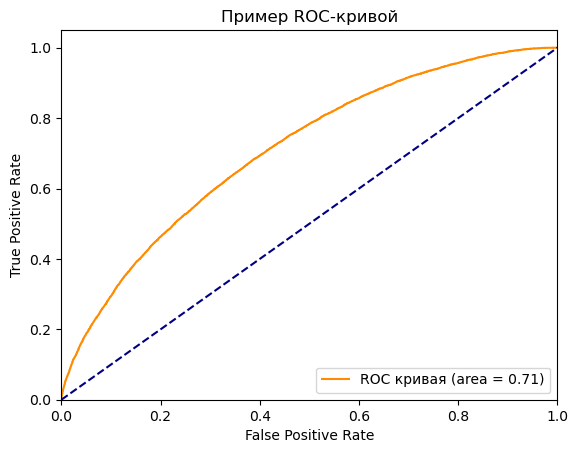

In [26]:
fpr, tpr, treshold = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right");

#### 3.BernoulliNB

In [30]:
br = BernoulliNB(alpha=1, binarize=0.0, fit_prior=True)
br.fit(x_train, y_train)

BernoulliNB(alpha=1)

In [31]:
br_preds = br.predict(x_test)
print(br.score(x_train, y_train))
print(accuracy_score(y_test, br_preds))
print(confusion_matrix(y_test, br_preds))
print(mean_absolute_error(y_test, br_preds))

0.6401813479031648
0.6451707691959947
[[21505  7987]
 [ 7711  7038]]
0.35482923080400536


In [32]:
preds = br.predict_proba(x_test)
br_probs = preds[:, 1]
br_auc = roc_auc_score(y_test, br_probs)
print('BernoulliNB: ROC AUC=%.3f' % (br_auc))

BernoulliNB: ROC AUC=0.666


In [34]:
cross_val_score(br, x, y, cv=4)

array([0.64032875, 0.63813166, 0.64122386, 0.63753492])

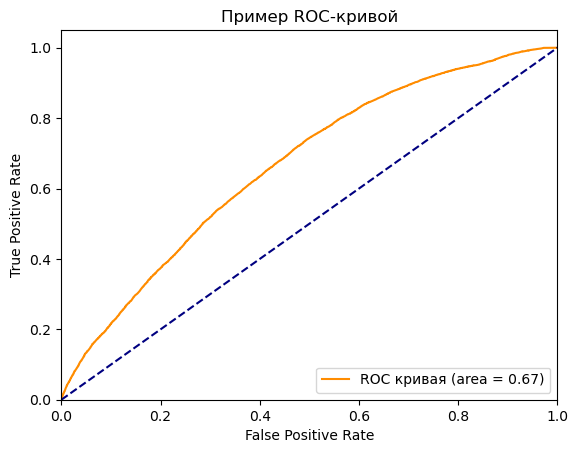

In [35]:
fpr, tpr, treshold = roc_curve(y_test, br_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right");

In [36]:
joblib.dump(logreg, 'logreg.pkl')
joblib.dump(rf, 'rf.pkl')
joblib.dump(br, 'br.pkl')

['br.pkl']